In [1]:
# Importing libraries and packages
import geopandas as gpd
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt

# Modeling
# Installing xgboost: conda install -c conda-forge xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn import metrics

# Feature importance visulization
import shap
from xgboost import plot_importance

# Save models
import pickle

### Load the TX/FL datasets and merge them

In [2]:
with open('../data/open-fema/FEMA-Large-DR-4332-TX.json','r') as f:
    femaData = json.loads(f.read())
femaDf_4332 = pd.json_normalize(femaData['fema_open_api'])
with open('../data/open-fema/FEMA-Large-DR-4337-FL.json','r') as f:
    femaData = json.loads(f.read())
femaDf_4337 = pd.json_normalize(femaData['fema_open_api'])
femaData = None

In [3]:
femaDf = pd.concat([femaDf_4332, femaDf_4337])
print('There are {} records combined.'.format(len(femaDf)))

There are 3538955 records combined.


In [4]:
femaDf.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'ownRent', 'residenceType', 'homeOwnersInsurance', 'floodInsurance',
       'inspected', 'rpfvl', 'habitabilityRepairsRequired', 'destroyed',
       'waterLevel', 'floodDamage', 'foundationDamage',
       'foundationDamageAmount', 'roofDamage', 'roofDamageAmount',
       'tsaEligible', 'tsaCheckedIn', 'rentalAssistanceEligible',
       'rentalAssistanceAmount', 'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id'],
      dtype='object')

### Select a subset of columns

https://docs.google.com/document/d/1nu0yENGAWnoiMcTufxYnH7xwdh8NfFum9ni9IYiSIdk/edit#

In [5]:
cols = ['householdComposition', 'specialNeeds', 'ownRent', 'residenceType', 'homeOwnersInsurance', 'floodInsurance', 
        'inspected', 'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage', 
        'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'rentalAssistanceAmount', 
        'repairAssistanceEligible', 'repairAmount', 'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible', 
        'primaryResidence']
femaDf = femaDf.loc[:, cols]

### Feature Engineering
TODO: Move this out of modeling

In [6]:
# Convert dtype from object to boolean
femaDf['habitabilityRepairsRequired'] = femaDf['habitabilityRepairsRequired'].astype('bool')
femaDf['primaryResidence'] = femaDf['primaryResidence'].astype('bool')

In [7]:
# Convert boolean columns to int
bool_cols = ['specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected', 'destroyed', 
             'habitabilityRepairsRequired', 'floodDamage', 'foundationDamage', 'roofDamage', 
             'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
             'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']
femaDf[bool_cols] = femaDf[bool_cols].astype(int)

In [8]:
# One-hot encode the categorical variables
cat_cols = ['ownRent', 'residenceType']
for col in cat_cols:
    femaDf = pd.concat([femaDf, pd.get_dummies(femaDf[col], prefix=col)], axis=1)
femaDf.drop(cat_cols, axis=1, inplace=True)

In [9]:
# Fill the na's with zero's in waterLevel
femaDf['waterLevel'].fillna(0, inplace=True)

In [10]:
# Define all the dollar amount columns
amount_cols = ['rentalAssistanceAmount', 'replacementAmount','repairAmount', 'rpfvl']
# Set them to zero if null
femaDf[amount_cols] = femaDf[amount_cols].fillna(0)
# Calculate the aggregated haAmount
femaDf['haAmount'] = femaDf['rentalAssistanceAmount'] + femaDf['replacementAmount'] + femaDf['repairAmount']

In [11]:
# Drop the individual amount columns
femaDf.drop(['rentalAssistanceAmount', 'replacementAmount','repairAmount'], axis=1, inplace=True)

In [12]:
femaDf.iloc[0]

householdComposition                      1.0
specialNeeds                              0.0
homeOwnersInsurance                       0.0
floodInsurance                            0.0
inspected                                 1.0
rpfvl                                     0.0
habitabilityRepairsRequired               0.0
destroyed                                 0.0
waterLevel                                0.0
floodDamage                               0.0
foundationDamage                          0.0
roofDamage                                0.0
tsaEligible                               1.0
rentalAssistanceEligible                  0.0
repairAssistanceEligible                  0.0
replacementAssistanceEligible             0.0
sbaEligible                               0.0
primaryResidence                          1.0
ownRent_Owner                             0.0
ownRent_Renter                            1.0
ownRent_Unknown                           0.0
residenceType_Apartment           

### Train/Test Split

In [13]:
# Split the data into train and test data
X = femaDf.loc[:, femaDf.columns != 'haAmount']
y = femaDf.loc[:, 'haAmount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2831164, 34) (2831164,)
(707791, 34) (707791,)


### RandomForest

https://machinelearningmastery.com/random-forest-ensemble-in-python/

- The “max_samples” argument can be set to a float between 0 and 1 to control the percentage of the size of the training dataset to make the bootstrap sample used to train each decision tree.
- max_features argument and defaults to the square root of the number of input features. 
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- The maximum tree depth can be specified via the max_depth argument and is set to None (no maximum depth) by default.

In [44]:
# RandomForest default model
model_rf = RandomForestRegressor(random_state = 42)

#### GridSearch

In [47]:
# Create the parameter grid
param_grid_rf = {
    'bootstrap': [True],
    'max_samples': [0.8, 0.9, 1.0],
    'max_depth': [6, 8],
    'n_estimators': [50, 75, 100]
}

In [48]:
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = model_rf, param_grid = param_grid_rf, scoring='neg_mean_absolute_error', cv = 3, n_jobs = -1, verbose = 2)

In [49]:
# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


One or more of the test scores are non-finite: [-88.72902265 -88.72745398 -88.81836287 -88.8871096  -88.86304247
 -88.90870066          nan          nan          nan -77.7995335
 -77.7969148  -77.83734534 -77.86331979 -77.85576354 -77.87194616
          nan          nan          nan]


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [6, 8],
                         'max_samples': [0.8, 0.9, 1.0],
                         'n_estimators': [50, 75, 100]},
             scoring='neg_mean_absolute_error', verbose=2)

In [50]:
grid_search_rf.best_params_

{'bootstrap': True, 'max_depth': 8, 'max_samples': 0.8, 'n_estimators': 75}

In [51]:
# Predict using best model
model_rf_best = grid_search_rf.best_estimator_
y_pred = model_rf_best.predict(X_test)

In [52]:
# Look at actual verus predicted
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
207189,0.0,0.0
672724,0.0,0.0
45822,0.0,0.0
800366,0.0,0.0
1853579,0.0,0.0
...,...,...
1332741,0.0,0.0
1388694,0.0,0.0
280917,0.0,0.0
2018796,0.0,0.0


In [53]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 77.37468460733453
Mean Squared Error: 306766.5852954174
Root Mean Squared Error: 553.8651327673709


In [55]:
results_df = pd.DataFrame({'actual':y_test, 'predicted':y_pred})

# Add column with difference of the two values
results_df['diff'] = results_df['predicted'] - results_df['actual']

# Add column that shows the percent difference between predicted and actual value
results_df['percent_diff'] = (abs(abs(results_df['predicted'] / (results_df['actual'])) - 1) * 100).where(results_df['actual'] > 0, 0)

# What percentage of predictions are off by 20%
len(results_df[results_df['percent_diff'] > 20])/len(results_df) * 100

4.48847187941073

In [54]:
for score, name in sorted(zip(model_rf_best.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

rpfvl 0.6396608173843942
repairAssistanceEligible 0.24601191623910196
rentalAssistanceEligible 0.05114357520452114
floodInsurance 0.030248138871940118
replacementAssistanceEligible 0.02365075457041492
habitabilityRepairsRequired 0.004289567130978741
residenceType_Travel Trailer 0.0013555248015706368
householdComposition 0.001051652551735724
waterLevel 0.00079879539841049
homeOwnersInsurance 0.0007159103128788752
residenceType_Mobile Home 0.00023685461456354306
sbaEligible 0.0002050586170305694
floodDamage 0.00017361706954943263
tsaEligible 9.310487675178284e-05
residenceType_House/Duplex 8.818061672492429e-05
inspected 7.236590908107954e-05
destroyed 6.327465828714257e-05
roofDamage 3.2908114136998935e-05
specialNeeds 2.9344911129552843e-05
residenceType_Boat 2.237159128144187e-05
foundationDamage 1.968945908183118e-05
residenceType_Townhouse 1.7302413817438546e-05
residenceType_Condo 7.012674295372815e-06
ownRent_Owner 6.452954513381527e-06
ownRent_Renter 2.385935242244264e-06
primary

In [58]:
# Save the model
pickle.dump(model_rf_best, open('random_forest.sav', 'wb'))

In [36]:
# Load saved model
model_rf_sav = pickle.load(open('random_forest.sav', 'rb'))
y_pred_sav = model_rf_sav.predict(X_test)
print('Total HA Amount predicted: ${:,.2f}'.format(y_pred_sav.sum()))
print('Total HA Amount actual: ${:,.2f}'.format(y_test.sum()))

Total HA Amount predicted: $388,187,890.71
Total HA Amount actual: $388,951,791.34


#### Variable Importance using Shapley (works best with smaller depth trees)

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [19]:
shap_model_rf = RandomForestRegressor(max_depth = 8, max_samples = 0.8, n_estimators = 100, random_state = 42)
shap_model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_samples=0.8, random_state=42)

In [ ]:
shap_values = shap.TreeExplainer(shap_model_rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)

### XGBoost 
https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

Hyperparameters:
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- Tree depth is controlled via the “max_depth” argument and defaults to 6.
- The learning rate can be controlled via the “eta” argument and defaults to 0.3.
- The number of samples used to fit each tree is specified by the “subsample” argument and can be set to a fraction of the training dataset size. By default, it is set to 1.0 to use the entire training dataset.
- The number of features used by each tree is taken as a random sample and is specified by the “colsample_bytree” argument and defaults to all features in the training dataset, e.g. 100 percent or a value of 1.0. 

In [14]:
# XGBRegressor default model
model_xgb = XGBRegressor(random_state = 42)

#### GridSearch

In [15]:
# Create the parameter grid
param_grid_xgb = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [6, 8, 10],
        'subsample': [0.8, 0.9],
        'n_estimators' : [50, 75, 100],
        'objective': ['reg:squarederror']
    }

In [16]:
# Instantiate the grid search model
grid_search_xgb = GridSearchCV(estimator = model_xgb, param_grid = param_grid_xgb, scoring='neg_mean_absolute_error', cv = 3, n_jobs = -1, verbose = 2)

In [17]:
grid_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_paramete

In [18]:
grid_search_xgb.best_params_

{'learning_rate': 0.05,
 'max_depth': 10,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [19]:
# Predict
model_xgb_best = grid_search_xgb.best_estimator_
y_pred = model_xgb_best.predict(X_test)

In [20]:
# Look at actual verus predicted
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
2112326,1307.0,1100.429321
263919,0.0,0.004627
878193,0.0,0.004627
1326350,0.0,0.004627
1363708,0.0,0.004627
...,...,...
1287471,0.0,0.004627
708829,0.0,0.004627
2072172,0.0,0.004627
1100879,0.0,0.004627


In [21]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 71.99058198593825
Mean Squared Error: 300116.4686836164
Root Mean Squared Error: 547.8288680633912


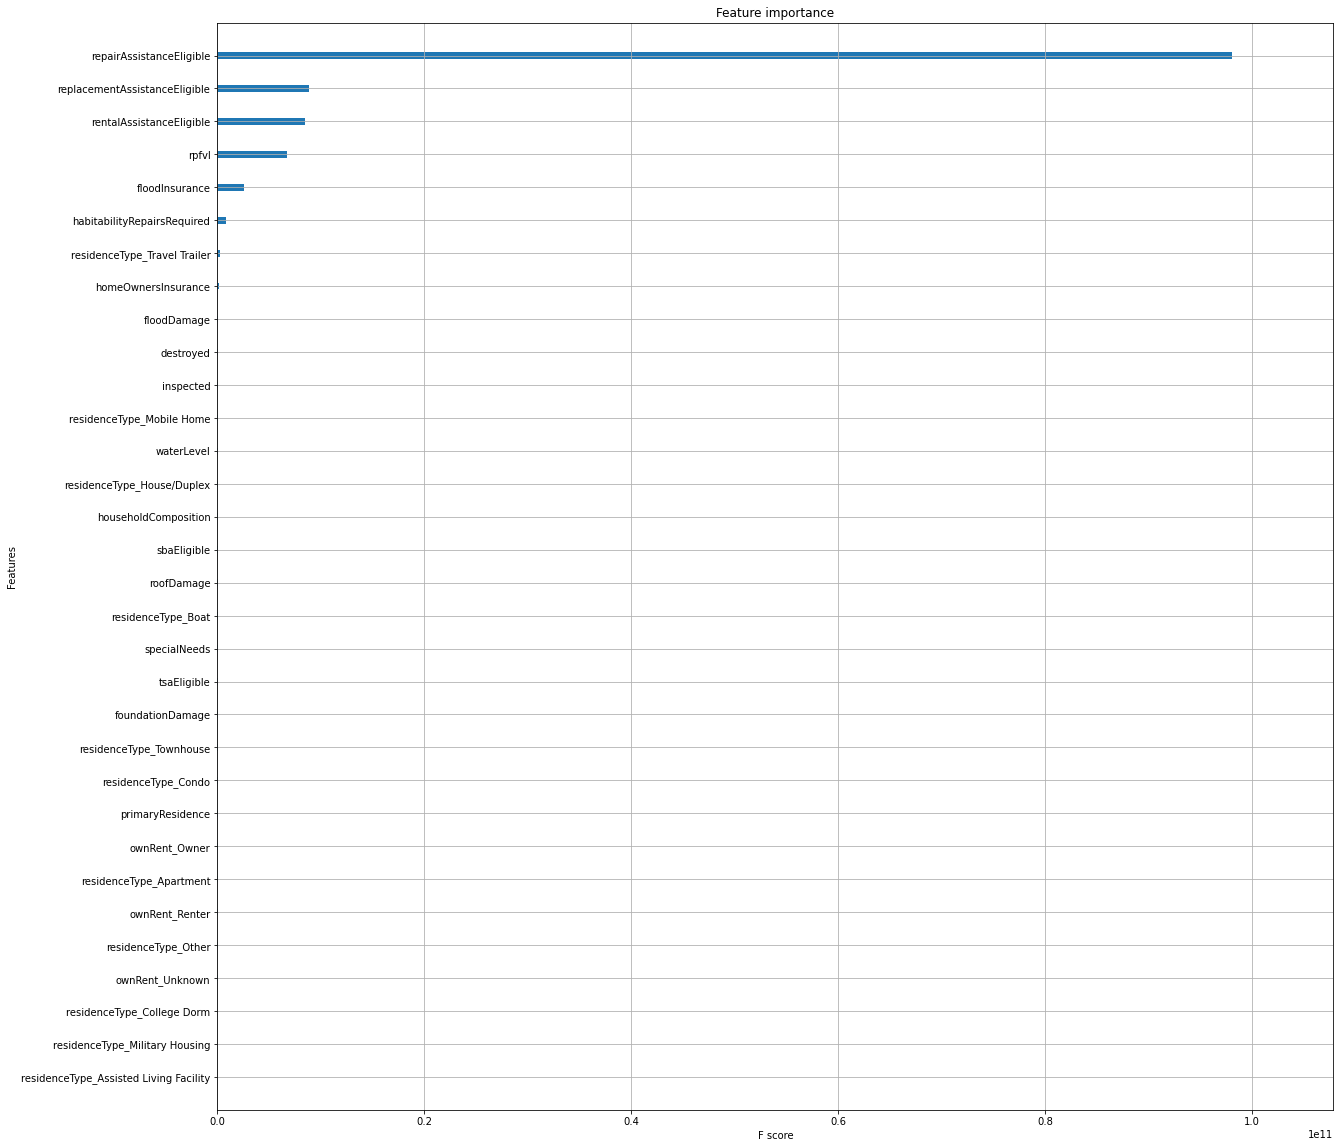

In [30]:
plot_importance(model_xgb_best, importance_type='gain', show_values = False)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [27]:
for score, name in sorted(zip(model_xgb_best.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

repairAssistanceEligible 0.77324325
replacementAssistanceEligible 0.070041284
rentalAssistanceEligible 0.06660522
rpfvl 0.05328465
floodInsurance 0.01991631
habitabilityRepairsRequired 0.006828687
residenceType_Travel Trailer 0.0022092946
homeOwnersInsurance 0.0011461547
floodDamage 0.00066782953
destroyed 0.00063731923
inspected 0.0005962014
residenceType_Mobile Home 0.0005508817
waterLevel 0.0004832015
residenceType_House/Duplex 0.00044225468
householdComposition 0.00043547462
sbaEligible 0.0004315173
roofDamage 0.00039468842
residenceType_Boat 0.00036679985
specialNeeds 0.00029144992
tsaEligible 0.00025229243
foundationDamage 0.00024763538
residenceType_Townhouse 0.00021058525
residenceType_Condo 0.00018491782
primaryResidence 0.00010446441
ownRent_Owner 0.00010125961
residenceType_Apartment 0.00010080211
ownRent_Renter 6.579925e-05
residenceType_Other 5.2975403e-05
ownRent_Unknown 4.970217e-05
residenceType_College Dorm 2.2300963e-05
residenceType_Military Housing 2.0359736e-05
res

In [28]:
results_df = pd.DataFrame({'actual':y_test, 'predicted':y_pred})

# Add column with difference of the two values
results_df['diff'] = results_df['predicted'] - results_df['actual']

# Add column that shows the percent difference between predicted and actual value
results_df['percent_diff'] = (abs(abs(results_df['predicted'] / (results_df['actual'])) - 1) * 100).where(results_df['actual'] > 0, 0)

# What percentage of predictions are off by 20%
len(results_df[results_df['percent_diff'] > 20])/len(results_df) * 100

4.314409197065236

In [31]:
# Save the model
pickle.dump(model_xgb_best, open('xgb_boost.sav', 'wb'))

In [35]:
# Load saved model
model_xgb_sav = pickle.load(open('xgb_boost.sav', 'rb'))
y_pred_sav = model_xgb_sav.predict(X_test)
print('Total HA Amount predicted: ${:,.2f}'.format(y_pred_sav.sum()))
print('Total HA Amount actual: ${:,.2f}'.format(y_test.sum()))

Total HA Amount predicted: $386,081,152.00
Total HA Amount actual: $388,951,791.34


#### Variable Importance using Shapley (works best with smaller depth trees)

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [ ]:
shap_values = shap.TreeExplainer(model_xgb_best).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)